In [124]:
# ------------------------------------
# 1. Core Data Manipulation & Visualization
# ------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ------------------------------------
# 2. Text Processing (NLP)
# ------------------------------------
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------
# 3. Feature Engineering & Preprocessing
# ------------------------------------
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ------------------------------------
# 4. Machine Learning Models
# ------------------------------------
from sklearn.naive_bayes import BernoulliNB

# ------------------------------------
# 5. Model Evaluation Metrics
# ------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_csv('spam.csv',encoding='latin-1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2317,ham,Waqt se pehle or naseeb se zyada kisi ko kuch ...,NaN,NaN,NaN
501,ham,When can Ì_ come out?,NaN,NaN,NaN
4280,ham,"Wn u r hurt by d prsn who s close 2 u, do figh...",NaN,NaN,NaN
1500,ham,Host-based IDPS for linux systems.,NaN,NaN,NaN
1258,ham,Honey boo I'm missing u.,NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

df.sample(5)

,label,message
955,ham,Sorry i now then c ur msg... Yar lor so poor t...
2746,ham,K da:)how many page you want?
1883,ham,"Come to me, slave. Your doing it again ... Goi..."
4520,ham,Hi good mornin.. Thanku wish u d same..
3305,ham,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...


In [4]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

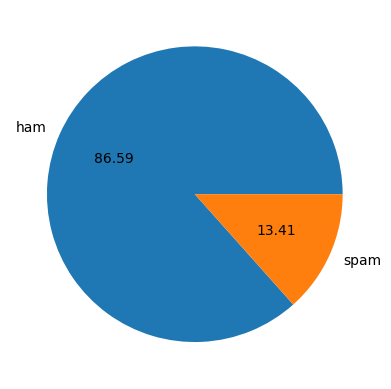

In [5]:
plt.pie(df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()



In [6]:
lb = LabelEncoder()
df['label'] = lb.fit_transform(df['label'])
df.sample(5)

,label,message
478,0,"K, can I pick up another 8th when you're done?"
3491,0,I will reach office around &lt;DECIMAL&gt; . ...
4198,1,"cmon babe, make me horny, *turn* me on! Txt me..."
5389,0,Ok.ok ok..then..whats ur todays plan
1027,0,Are you not around or just still asleep? :V


In [7]:
# check for duplicate values
df.duplicated().sum()

np.int64(403)

In [8]:
df.drop_duplicates(keep='first', inplace=True)

In [9]:
df.shape

(5169, 2)

Spam doesn't just differ from ham by a single word;
it's the frequency of certain words,
the structure of the email, the presence of specific symbols or links, etc.

So We will need to create additional columns to avoid the problem of under-fitting
Cuz we just have 2 columns

So we will add columns such as number of tokens, Characters Count,...

In [10]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
df['tokens_count'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df['char_count'] = df['message'].apply(len)

In [12]:
df.sample(5)

,label,message,tokens_count,char_count
1780,1,BIG BROTHER ALERT! The computer has selected u...,31,154
4808,0,"Don't worry though, I understand how important...",44,201
1764,1,Hi 07734396839 IBH Customer Loyalty Offer: The...,30,143
1896,0,I tot u outside cos darren say u come shopping...,27,110
4914,0,We took hooch for a walk toaday and i fell ove...,30,134


In [13]:
df.groupby('label').describe()

tokens_count                                                      \
             count       mean        std  min   25%   50%   75%    max   
label                                                                    
0           4516.0  17.123782  13.493970  1.0   8.0  13.0  22.0  220.0   
1            653.0  27.667688   7.008418  2.0  25.0  29.0  32.0   46.0   

      char_count                                                           
           count        mean        std   min    25%    50%    75%    max  
label                                                                      
0         4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0  910.0  
1          653.0  137.891271  30.137753  13.0  132.0  149.0  157.0  224.0

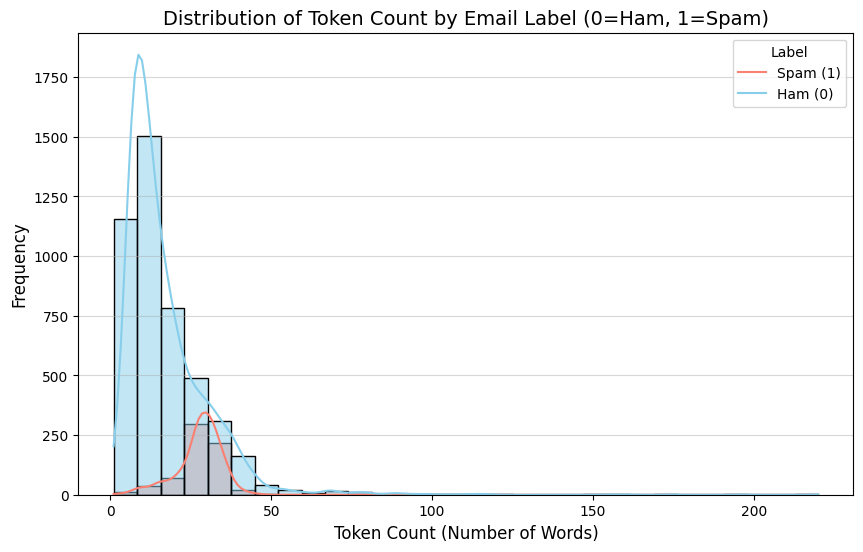

In [14]:

# --- 1. Histogram for Tokens Count per Label ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tokens_count', hue='label', kde=True, bins=30, palette={0: 'skyblue', 1: 'salmon'})
plt.title('Distribution of Token Count by Email Label (0=Ham, 1=Spam)', fontsize=14)
plt.xlabel('Token Count (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['Spam (1)', 'Ham (0)'])
plt.grid(axis='y', alpha=0.5)


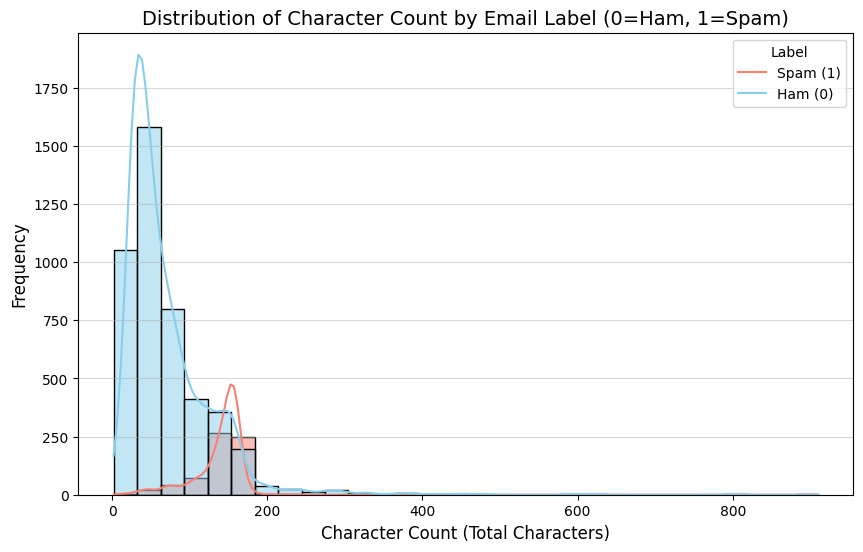

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='char_count', hue='label', kde=True, bins=30, palette={0: 'skyblue', 1: 'salmon'})
plt.title('Distribution of Character Count by Email Label (0=Ham, 1=Spam)', fontsize=14)
plt.xlabel('Character Count (Total Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['Spam (1)', 'Ham (0)'])
plt.grid(axis='y', alpha=0.5)

In [16]:
def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # tokenization 
    tokens = nltk.word_tokenize(text)
    #Remove stopwords (requires NLTK)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Example usage:
df['clean_message'] = df['message'].apply(clean_text)

In [17]:
df.drop('message', axis=1, inplace=True)
df.sample(5)

,label,tokens_count,char_count,clean_message
890,0,6,24,ask princess
107,0,15,82,would ip address test considering computer isn...
5294,1,24,157,xmas iscoming ur awarded either å£ cd gift vou...
4063,0,33,122,prof passed papers sem congrats student enna k...
5282,0,12,49,gone get info bt dont know


In [18]:
stemmer = SnowballStemmer("english")

In [19]:
df['clean_message'] = df['clean_message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [20]:
df.sample(5)

,label,tokens_count,char_count,clean_message
380,0,70,300,guess that worri must know there way bodi repa...
4883,0,21,113,mani thing antibiot use chest abdomen gyna inf...
584,0,21,95,how scotland hope show jjc tendenc take care l...
897,0,39,154,im use hope agent dont drop sinc ive book thin...
4124,0,12,55,may b approv panalambut post


In [21]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

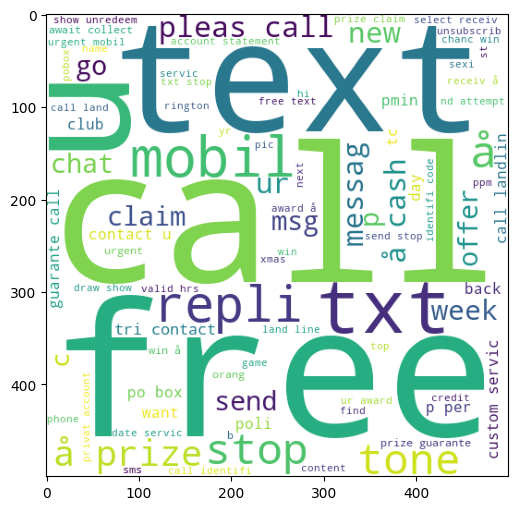

In [22]:
spam_wc = wc.generate(df[df['label'] == 1]['clean_message'].str.cat(sep=" "))
plt.figure(figsize=(10,6))
plt.imshow(spam_wc)

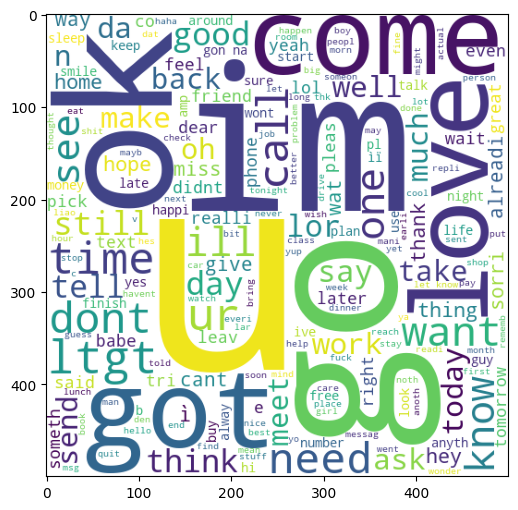

In [23]:
spam_wc = wc.generate(df[df['label'] == 0]['clean_message'].str.cat(sep=" "))
plt.figure(figsize=(10,6))
plt.imshow(spam_wc)

In [172]:
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

In [173]:
X = tfidf_vectorizer.fit_transform(df['clean_message']).toarray()

In [174]:
X.shape

(5169, 2000)

In [175]:
# appending the num_character col to X

manual_features = df[['char_count', 'tokens_count']]

# Convert manual features to sparse matrix (matching the sparse X_text format)
manual_features_sparse = csr_matrix(manual_features.values)

X_final = hstack([X, manual_features_sparse])

In [176]:
X_final.shape

(5169, 2002)

In [177]:
y = df['label'].values

In [178]:
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_sm, y_sm = smote.fit_resample(X_final, y)


In [179]:
print("Original Training Set Distribution: %s" % Counter(y))
print("SMOTE Training Set Distribution: %s" % Counter(y_sm))

Original Training Set Distribution: Counter({np.int64(0): 4516, np.int64(1): 653})
SMOTE Training Set Distribution: Counter({np.int64(0): 4516, np.int64(1): 4516})


In [180]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X_sm.toarray())

In [181]:
X_train,X_test,y_train,y_test = train_test_split(X,y_sm,test_size=0.2,random_state=42, stratify=y_sm)

In [182]:
bnb = BernoulliNB()

In [183]:
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)

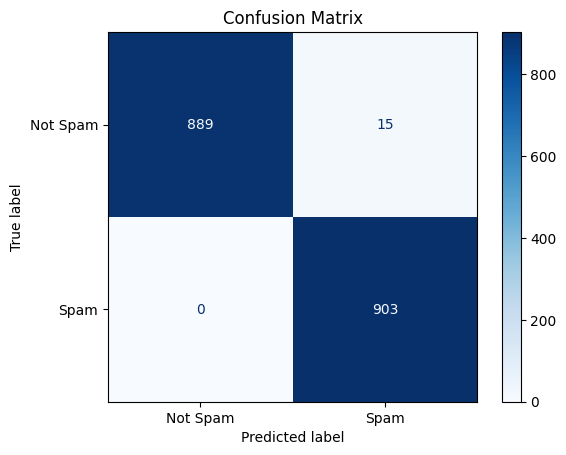

In [ ]:
cm = confusion_matrix(y_test, y_pred)
# Initialize the display using the calculated matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Spam', 'Spam']
)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues) # 'plt.cm.Blues' provides a nice color scheme

# Add a title and show the plot
plt.title('Confusion Matrix')
plt.show()

In [186]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       931
           1       0.97      1.00      0.98       876

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



In [187]:
def preprocess_for_predict(new_messages, tfidf_vectorizer, scaler):
    """
    Applies the exact same feature engineering and scaling steps
    to new, unseen messages for model prediction.

    Args:
        new_messages (list or pd.Series): A list or Series of raw email strings.
        tfidf_vectorizer: The TfidfVectorizer object fitted on the training data.
        scaler: The MinMaxScaler object fitted on the training data.

    Returns:
        numpy.ndarray: The final, scaled feature array ready for model.predict().
    """
    
    if isinstance(new_messages, str):
        # Handle single string input by wrapping it in a list/Series
        new_messages = pd.Series([new_messages])

    # Create a temporary DataFrame for feature calculation
    temp_df = pd.DataFrame({'message': new_messages})
    
    # 1. Feature Engineering (Must be calculated on the raw message)
    temp_df['tokens_count'] = temp_df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
    temp_df['char_count'] = temp_df['message'].apply(len)

    # 2. Text Cleaning and Stemming
    temp_df['clean_message'] = temp_df['message'].apply(clean_text)
    stemmer = SnowballStemmer("english")
    temp_df['clean_message'] = temp_df['clean_message'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
    )

    # 3. Text Vectorization (MUST USE .transform())
    X_text = tfidf_vectorizer.transform(temp_df['clean_message'])
    
    # 4. Feature Combination
    manual_features = temp_df[['char_count', 'tokens_count']]
    manual_features_sparse = csr_matrix(manual_features.values)
    
    # Combine sparse text features and sparse manual features
    X_combined = hstack([X_text, manual_features_sparse])
    
    # 5. Scaling (MUST USE .transform())
    # Convert to dense before scaling
    X_final_scaled = scaler.transform(X_combined.toarray())
    
    return X_final_scaled

In [200]:
def predict(model,emails):
    X_predict = preprocess_for_predict(new_emails, tfidf_vectorizer, scaler)
    return model.predict(X_predict)


new_emails = [
    # --- Example Ham (Non-Spam) Messages ---
    "Regarding the team meeting scheduled for tomorrow, please review the attached document before 10 AM. Agenda is collaboration status.",
    "Can you confirm receipt of the invoice #90123? We need payment processed by the end of the week. Thanks!",
    "Just checking in on the project deadline. Are we still on track for the July 15th release? Let me know if you need anything.",
    
    # --- Example Spam Messages ---
    "URGENT PRIZE NOTIFICATION!!! Click here NOW to claim your FREE MILLION DOLLARS! Limited time offer, ACT FAST: http://tinyurl.com/scam",
    "Dear valued member, YOUR ACCOUNT HAS BEEN SUSPENDED. Verify your details immediately to avoid deactivation via this link: http://phishing.net/login",
    "VIAGRA 80% OFF! Do not miss this CHANCE to get the best deal. Use code FREEBIE at checkout. GUARANTEED!!!",
    
    # --- Mixed/Tricky Message ---
    "Hello! I found a great deal on a new watch at Amazon. It's 50% off if you use this coupon code. I'll send the link separately." 
]
print(predict(bnb,new_emails))

[0 0 0 1 1 1 0]


# Implementing ANN

In [190]:
input_dim = X_train.shape[1]
input_dim

2002

In [192]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# from sklearn.metrics import recall_score, precision_score, classification_report

In [193]:
model = Sequential([
    # Input Layer and First Hidden Layer
    # Use 'relu' for the activation function (common choice)
    Dense(128, input_dim=input_dim, activation='relu', name='Hidden_Layer_1'),
    # Dropout layer to prevent overfitting (important for ANNs)
    Dropout(0.3),
    
    # Second Hidden Layer
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.3),
    
    # Output Layer
    # Use 1 unit for binary classification
    # Use 'sigmoid' activation to output a probability between 0 and 1
    Dense(1, activation='sigmoid', name='Output_Layer')
])

c:\Users\dell\Documents\Spam-Detector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [208]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# Optional: View the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │       256,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,705 (1.01 MB)

 Trainable params: 264,705 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [212]:
# 4. Train the Model
history = model.fit(
    X_train, 
    y_train, 
    epochs=4,          # Number of passes over the training data
    batch_size=32,      # Number of samples per gradient update
    validation_split=0.1, # Use 10% of training data for validation during training
    verbose=1
)

Epoch 1/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0031 - recall: 0.9982 - val_accuracy: 0.9931 - val_loss: 0.0589 - val_recall: 1.0000
Epoch 2/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9989 - loss: 0.0029 - recall: 0.9982 - val_accuracy: 0.9959 - val_loss: 0.0514 - val_recall: 1.0000
Epoch 3/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0027 - recall: 0.9982 - val_accuracy: 0.9917 - val_loss: 0.0613 - val_recall: 1.0000
Epoch 4/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0027 - recall: 0.9982 - val_accuracy: 0.9917 - val_loss: 0.0608 - val_recall: 1.0000


In [213]:
# 5. Evaluate the Model on Test Data
# Use the best recall model from the voting classifier as a baseline.
loss, accuracy, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"\nANN Test Accuracy: {accuracy:.4f}")
print(f"ANN Test Recall: {recall:.4f}")

# 6. Final Predictions and Metrics
# ANN outputs probabilities (0 to 1). We need to set the threshold.
# Since recall is crucial, you can use the standard 0.5 or lower it (e.g., 0.3) 
# if recall needs to be pushed further.
y_pred_proba = model.predict(X_test)
THRESHOLD = 0.5 
y_pred = (y_pred_proba > THRESHOLD).astype(int)

print("\n--- Classification Report (ANN) ---")
print(classification_report(y_test, y_pred))


ANN Test Accuracy: 0.9917
ANN Test Recall: 1.0000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Classification Report (ANN) ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       904
           1       0.98      1.00      0.99       903

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807



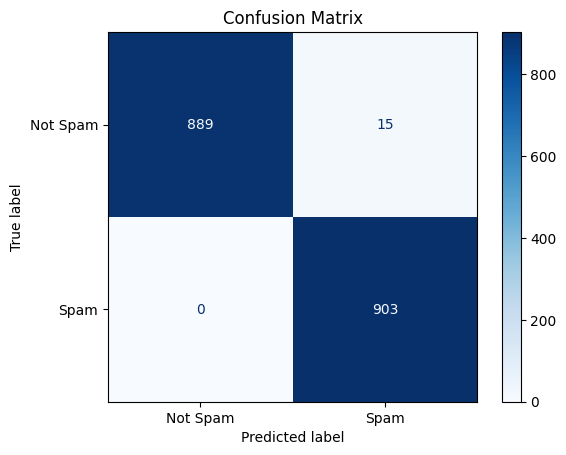

In [216]:
cm = confusion_matrix(y_test, y_pred)
# Initialize the display using the calculated matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Spam', 'Spam']
)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues) # 'plt.cm.Blues' provides a nice color scheme

# Add a title and show the plot
plt.title('Confusion Matrix')
plt.show()

In [218]:
new_emails = [
    # --- Example Ham (Non-Spam) Messages ---
    "Regarding the team meeting scheduled for tomorrow, please review the attached document before 10 AM. Agenda is collaboration status.",
    "Can you confirm receipt of the invoice #90123? We need payment processed by the end of the week. Thanks!",
    "Just checking in on the project deadline. Are we still on track for the July 15th release? Let me know if you need anything.",
    
    # --- Example Spam Messages ---
    "URGENT PRIZE NOTIFICATION!!! Click here NOW to claim your FREE MILLION DOLLARS! Limited time offer, ACT FAST: http://tinyurl.com/scam",
    "Dear valued member, YOUR ACCOUNT HAS BEEN SUSPENDED. Verify your details immediately to avoid deactivation via this link: http://phishing.net/login",
    "VIAGRA 80% OFF! Do not miss this CHANCE to get the best deal. Use code FREEBIE at checkout. GUARANTEED!!!",
    
    # --- Mixed/Tricky Message ---
    "Hello! I found a great deal on a new watch at Amazon. It's 50% off if you use this coupon code. I'll send the link separately." 
]
print(predict(bnb,new_emails))

[0 0 0 1 1 1 0]
